In [15]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from math import log10, floor
import os
import glob
import matplotlib.pyplot as plt
import datetime
from math import ceil, isnan
import sys
try:
    import torchtext
    from torchtext.data import Field, Iterator, Dataset, Example
except ImportError: 
    !{'/opt/anaconda3/bin/python3'} -m pip install --upgrade git+https://github.com/pytorch/text
    import torchtext
    from torchtext.data import Field, Iterator, Dataset

from relational_rnn_models import RelationalMemoryGenerator
from discriminator import RelGANDiscriminator

cuda = torch.cuda.is_available()

# Try setting the device to a GPU
device = torch.device("cuda:0" if cuda else "cpu")
print('Device:', device)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Device: cuda:0


In [3]:
# Helper function(s)

# round a number to n significant digits
def round_to_n(x, n = 2):
    return round(x, -int(floor(log10(abs(x)))) + (n - 1)) if x != 0 else 0

# Transform a date string into a datetime object
def str_to_datetime(string):
    return datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

# TODO: more complex reduction: takes into account different ICD groups?
def reduce_icd(icd_full):
    return icd_full[:2]

def get_distribution(data, vocab_size):
    counts = torch.zeros(vocab_size)

    for i in range(vocab_size):
        counts[i] = torch.sum(data == i)

    freqs = counts / torch.sum(counts)
    
    return counts, freqs
    

In [4]:
icd_codes = pd.read_csv('D_ICD_DIAGNOSES.csv.gz', compression='gzip', index_col='ROW_ID')

date_time_events = pd.read_csv('DATETIMEEVENTS.csv.gz', compression='gzip', usecols=['SUBJECT_ID', 'HADM_ID', 'CHARTTIME'])

diagnoses = pd.read_csv('DIAGNOSES_ICD.csv.gz', compression='gzip', usecols=['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'])

date_time_events['CHARTTIME'] = date_time_events['CHARTTIME'].map(str_to_datetime)

In [5]:
filtered_diagnoses = diagnoses[diagnoses['SEQ_NUM'] == 1.0].drop('SEQ_NUM', axis=1)

filtered_diagnoses['ICD9_CODE'] = filtered_diagnoses['ICD9_CODE'].map(reduce_icd)

print(filtered_diagnoses.head())

def apply_func(x):
    return x.loc[x['CHARTTIME'].idxmin()]

processed_events = date_time_events.groupby('HADM_ID').apply(apply_func).reset_index(drop=True)
print(processed_events.head())

    SUBJECT_ID  HADM_ID ICD9_CODE
0          109   172335        40
14         109   173633        40
28         112   174105        53
33         113   109976        19
36         114   178393        41
   SUBJECT_ID   HADM_ID           CHARTTIME
0       58526  100001.0 2117-09-11 11:47:00
1       54610  100003.0 2150-04-17 15:35:00
2       23018  100007.0 2145-03-31 10:15:00
3         533  100009.0 2162-05-17 10:18:00
4       55853  100010.0 2109-12-10 21:58:00


In [6]:
merged = pd.merge(filtered_diagnoses, processed_events)
#merged.isnull().any() # All False

def filter_func(x):
    return len(x) > 1

final_events = merged.groupby('SUBJECT_ID').filter(filter_func)#.reset_index(drop=True)
final_events.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,CHARTTIME
0,109,172335,40,2141-09-20 20:44:00
1,109,173633,40,2141-12-08 01:41:00
5,124,112906,44,2161-12-24 12:00:00
6,124,134369,44,2165-05-30 08:59:00
7,124,138376,56,2166-01-09 13:05:00


In [7]:
print(final_events.groupby('SUBJECT_ID').apply(lambda x: (x['CHARTTIME'].max() - x['CHARTTIME'].min()).days).describe())
print(final_events.groupby('SUBJECT_ID').apply(lambda x: len(x)).describe())

count    4337.000000
mean      468.675121
std       570.848641
min         0.000000
25%        52.000000
50%       217.000000
75%       689.000000
max      2991.000000
dtype: float64
count    4337.000000
mean        2.620936
std         1.476196
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        33.000000
dtype: float64


In [8]:
sequence_length = final_events.groupby('SUBJECT_ID').apply(lambda x: len(x)).max()

def get_sequence_of_codes(subject):
    #codes = ['None' for _ in range(sequence_length)]
    codes = []
    
    for enum, i in enumerate(subject.sort_values('CHARTTIME').index):
        #codes[enum] = subject.loc[i, 'ICD9_CODE']
        codes.append(subject.loc[i, 'ICD9_CODE'])
        
    #res = pd.Series(codes)
    res = ' '.join(codes)
    return res

def get_sequence_of_time_differences(subject):
    #times = [0 for _ in range(sequence_length)]
    times = []
    
    day0 = subject['CHARTTIME'].min()
    
    for enum, i in enumerate(subject.sort_values('CHARTTIME').index):
        #times[enum] = (subject.loc[i, 'CHARTTIME'] - day0).days
        times.append((subject.loc[i, 'CHARTTIME'] - day0).days)
        
    #res = pd.Series(times)
    res = times
    return res
    

In [9]:
sequences_of_codes = final_events.groupby('SUBJECT_ID').apply(get_sequence_of_codes)
print(sequences_of_codes.head())
print(sequences_of_codes.shape)

sequences_of_times = final_events.groupby('SUBJECT_ID').apply(get_sequence_of_time_differences)
print(sequences_of_times.head())
print(sequences_of_times.shape)

SUBJECT_ID
17       74 42
21       41 03
23       41 22
36    41 99 55
68       04 04
dtype: object
(4337,)
SUBJECT_ID
17         [0, 131]
21         [0, 140]
23        [0, 1507]
36    [0, 12, 1103]
68          [0, 22]
dtype: object
(4337,)


In [10]:
#sequences = pd.DataFrame({'ICD9_CODE': sequences_of_codes.stack(), 'TIME_FROM_PREVIOUS': sequences_of_times.stack()})
sequences = pd.DataFrame({'ICD9_CODE': sequences_of_codes, 'TIME_FROM_PREVIOUS': sequences_of_times})
print(sequences.shape)
sequences.head()


(4337, 2)


,ICD9_CODE,TIME_FROM_PREVIOUS
SUBJECT_ID,,
17,74 42,"[0, 131]"
21,41 03,"[0, 140]"
23,41 22,"[0, 1507]"
36,41 99 55,"[0, 12, 1103]"
68,04 04,"[0, 22]"


In [28]:
# https://stackoverflow.com/questions/52602071/dataframe-as-datasource-in-torchtext

class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.fields = dict(fields)
        self.examples = examples.apply(SeriesExample.fromSeries, args=(self.fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
    
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [29]:
tokenize = lambda x: x.split(' ')

ICD9_CODE = Field(fix_length = sequence_length, tokenize = tokenize)

fields = [('ICD9_CODE', ICD9_CODE), ('TIME_FROM_PREVIOUS', None)]

dataset = DataFrameDataset(sequences, fields)

ICD9_CODE.build_vocab(dataset)
#dataset.examples

In [58]:
print(ICD9_CODE.vocab.stoi['00'])
print(ICD9_CODE.vocab.itos[31])
vocab_size = len(ICD9_CODE.vocab.freqs)
print(vocab_size)
ICD9_CODE.vocab.stoi

31
00
96


Counter({'74': 14,
         '42': 1185,
         '41': 733,
         '03': 1186,
         '22': 28,
         '99': 980,
         '55': 139,
         '04': 60,
         '27': 129,
         '33': 21,
         '53': 261,
         '71': 51,
         '43': 456,
         '40': 150,
         '45': 155,
         '96': 84,
         '48': 407,
         '44': 269,
         '56': 294,
         '18': 30,
         '85': 153,
         '57': 680,
         '32': 35,
         '16': 91,
         '49': 197,
         '15': 139,
         '19': 230,
         '34': 135,
         '50': 204,
         '58': 211,
         'V3': 32,
         '77': 15,
         '39': 75,
         '51': 783,
         '23': 19,
         '07': 50,
         '25': 333,
         '11': 26,
         '69': 14,
         '80': 131,
         'V5': 55,
         '78': 104,
         '59': 92,
         '20': 91,
         '82': 65,
         '00': 86,
         '52': 6,
         '79': 34,
         '72': 51,
         '93': 14,
         '28': 76,
     

In [56]:
batch_size = 64
data_iter = Iterator(dataset, batch_size = batch_size)#, device = device)

next(iter(data_iter)).ICD9_CODE.transpose(0, 1)

tensor([[ 3,  3,  1,  ...,  1,  1,  1],
        [ 7,  7, 18,  ...,  1,  1,  1],
        [ 2, 26, 31,  ...,  1,  1,  1],
        ...,
        [ 3,  7,  1,  ...,  1,  1,  1],
        [ 2,  2, 32,  ...,  1,  1,  1],
        [ 9,  5,  1,  ...,  1,  1,  1]])

In [81]:
subjects = pd.unique(final_events['SUBJECT_ID'])
n_individuals = len(subjects)
print(n_individuals)

4337


In [49]:
#divisor = 365 * 5
#sequence_length = ceil((t1 - t0).days / divisor)
'''
print(sequence_length, sequence_length * len(subjects))

flat_codes = sequences_of_codes.values.flatten()
flat_codes = flat_codes[flat_codes != 'None']

codes = np.concatenate([np.array(['None']), np.unique(flat_codes)])
print(codes)

codes_size = len(codes)
print(codes_size)

code_to_index = dict([(c, i) for i, c in enumerate(codes)])
index_to_code = dict([(i, c) for i, c in enumerate(codes)])

print(index_to_code[12], type(index_to_code[12]))
print(code_to_index['77'])
print(code_to_index['None'] == 0)'''

"\nprint(sequence_length, sequence_length * len(subjects))\n\nflat_codes = sequences_of_codes.values.flatten()\nflat_codes = flat_codes[flat_codes != 'None']\n\ncodes = np.concatenate([np.array(['None']), np.unique(flat_codes)])\nprint(codes)\n\ncodes_size = len(codes)\nprint(codes_size)\n\ncode_to_index = dict([(c, i) for i, c in enumerate(codes)])\nindex_to_code = dict([(i, c) for i, c in enumerate(codes)])\n\nprint(index_to_code[12], type(index_to_code[12]))\nprint(code_to_index['77'])\nprint(code_to_index['None'] == 0)"

In [47]:
# Transform the data into a reasonnable format
'''
data_seqs = torch.zeros(n_individuals, 2, sequence_length)

data_seqs[:, 0, :] = torch.from_numpy(sequences_of_codes.apply(lambda x: x.apply(lambda y: code_to_index[y])).values)
data_seqs[:, 1, :] = torch.from_numpy(sequences_of_times.values)

data = data_seqs[:, 0, :]

print(data_seqs)
print(data)'''

'\ndata_seqs = torch.zeros(n_individuals, 2, sequence_length)\n\ndata_seqs[:, 0, :] = torch.from_numpy(sequences_of_codes.apply(lambda x: x.apply(lambda y: code_to_index[y])).values)\ndata_seqs[:, 1, :] = torch.from_numpy(sequences_of_times.values)\n\ndata = data_seqs[:, 0, :]\n\nprint(data_seqs)\nprint(data)'

In [48]:
'''print(torch.sum(data != 0).type(torch.FloatTensor) / data.numel()) # Percentage of non-zero elements
print(data[:3])
'''

'print(torch.sum(data != 0).type(torch.FloatTensor) / data.numel()) # Percentage of non-zero elements\nprint(data[:3])\n'

In [50]:
# Find the distribution of the data
'''
counts, freqs = get_distribution(data, codes_size)

print(counts)
print(freqs)'''

'\ncounts, freqs = get_distribution(data, codes_size)\n\nprint(counts)\nprint(freqs)'

In [57]:
# Test generator output

mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

start_token = torch.tensor([[0]])
memory = G.initial_state(batch_size = 1)

if cuda:
    G.cuda()
    start_token = start_token.cuda()
    memory = memory.cuda()

print(memory)
logits, tokens, _, memory = G(start_token, memory, sequence_length, None)
print(logits)
print(tokens)
print(memory)


tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')
tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[ 0, 65,  5, 36,  8, 69,  5, 39, 45, 18, 27, 71, 80, 30, 88, 46,  1, 83,
         39, 83, 90, 27, 42, 42, 29, 64, 72, 41, 79, 81, 95, 81, 74]],
       device='cuda:0')
tensor([[[-1.9889,  0.2935, -0.8093,  1.0253],
         [-2.2006,  0.3083, -0.8785,  1.0235],
         [-2.1808,  0.2980, -0.8788,  1.0242],
         [-2.1454,  0.2995, -0.8676,  1.0240]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [95]:
# Define generator evaluation functions

def chi_sqrd_dist(counts1, counts2):
    counts1 = counts1.view(1, -1)
    counts2 = counts2.view(1, -1)
    table = torch.cat([counts1, counts2], dim = 0)
    col_sums = torch.sum(table, dim = 0)
    row_sums = torch.sum(table, dim = 1)
    n = torch.sum(col_sums)
    
    table_freq = table / n
    col_freqs = col_sums / n
    row_freqs = row_sums / n
    
    diffs = table_freq[0, :] / row_freqs[0] - table_freq[1, :] / row_freqs[1]
    diffs_sqrd = diffs ** 2
    diffs_sqrd_norm = diffs_sqrd / col_freqs
    
    chi_sqrd_distance = torch.sum(diffs_sqrd_norm)
    
    return chi_sqrd_distance
    
def test_special_case(G, ICD9_CODE, start_tokens, vocab_size = vocab_size, sequence_length = sequence_length):
    counts_real = ICD9_CODE.vocab.freqs
    
    memory = G.initial_state(batch_size = start_tokens.shape[0])

    if cuda:
        memory = memory.cuda()
        start_tokens = start_tokens.cuda()
    
    _, data_fake, _, _ = G(start_tokens, memory, sequence_length)
    
    counts_fake, freqs_fake = get_distribution(data_fake, vocab_size)
    
    score = chi_sqrd_dist(counts_real, counts_fake)
    return score

score = test_special_case(G, ICD9_CODE, data[:50, :1])
print(score)

tensor(3.3806)


In [96]:
# Test Discriminator output

n_embeddings = 2
embed_size = 2
out_channels = 5 
filter_sizes = [2, 3] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    D.cuda()

inp = logits
print(inp)
print(D(inp, False))
print(D(inp))


tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0',
       grad_fn=<CatBackward>)
tensor([[0.3010, 0.3265]], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.3137], device='cuda:0', grad_fn=<MeanBackward2>)


In [203]:
# Define the generator pre-train function

# TODO: use some data or batch loader from torchtext
def pretrain_generator(G, dataset, batch_size, vocab_size, n_epochs, lr, print_step = 10):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(G.parameters(), lr=lr)
    
    sequence_length = train_data.shape[1]
    n_individuals = train_data.shape[0]
    
    if cuda:
        G.cuda()
        loss_function.cuda()
    
    for e in range(n_epochs):
        for batch_i in range(0, n_individuals, batch_size):
            data = train_data[batch_i:batch_i + batch_size]
            data_one_hot = F.one_hot(data, vocab_size).type(Tensor)
            
            start_token = data[:, :1]
            optimizer.zero_grad()

            memory = G.initial_state(batch_size = batch_size)

            if cuda:
                start_token = start_token.cuda()
                memory = memory.cuda()

            logits, _, _, _ = G(start_token, memory, sequence_length)

            loss = loss_function(logits, data_one_hot)

            loss.backward()
            optimizer.step()
        
        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [G loss: %f]"
                % (e, n_epochs, loss.item())
            )

In [204]:
mem_slots = 4
head_size = 2
embed_size = 2
temperature = 1
num_heads = 2

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads)

if cuda:
    G.cuda()

score = test_special_case(G, data, vocab_size, False)
print(score)
pretrain_generator(G, data, vocab_size, 10, 0.01, 2)
score = test_special_case(G, data, vocab_size, False)
print(score)

tensor(3.4362)
[Epoch 0/10] [G loss: 0.546688]
[Epoch 2/10] [G loss: 0.540247]
[Epoch 4/10] [G loss: 0.505934]
[Epoch 6/10] [G loss: 0.441500]
[Epoch 8/10] [G loss: 0.275778]
tensor(0.3093)


In [205]:
# Define the training function

# TODO: use some data or batch loader from torchtext
def train(G, D, train_data, vocab_size, n_epochs, lr, temperature, print_step = 10, score_fn = test_special_case):    
    scores = []
    
    score = test_special_case(G, data, vocab_size, False)
    print('Score before training:', score)
    scores.append(torch.tensor(score))
    
    print('pretraining generator...')
    pretrain_generator(G, train_data, vocab_size, max(n_epochs // 10, 1), lr * 100, max(n_epochs // 10 - 1, 1))
    print('pretraining complete')
    
    score = test_special_case(G, data, vocab_size, False)
    print("[Score:", score, "]")
    scores.append(torch.tensor(score))
    
    adversarial_loss = torch.nn.BCELoss()
    
    optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
    
    train_data_one_hot = F.one_hot(train_data, vocab_size).type(Tensor)

    start_token = train_data[:, :1]
    sequence_length = train_data.shape[1]
    
    if cuda:
        G.cuda()
        D.cuda()
        adversarial_loss.cuda()
        start_token = start_token.cuda()
    
    for e in range(n_epochs):
        # Adversarial ground truths
        valid = Variable(Tensor(train_data.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(train_data.shape[0], 1).fill_(0.0), requires_grad=False)

        optimizer_G.zero_grad()

        # Generate a batch of images
        memory = G.initial_state(batch_size = train_data.shape[0])
        if cuda:
            memory = memory.cuda()
        temp = temperature ** ((e + 1) / n_epochs)
        fake_one_hot, _, _, _ = G(start_token, memory, sequence_length, temp)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(fake_one_hot), valid)

        g_loss.backward()
        optimizer_G.step()
        
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(D(train_data_one_hot), valid)
        fake_loss = adversarial_loss(D(fake_one_hot.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if e % print_step == 0:
            print(
                "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
                % (e, n_epochs, d_loss.item(), g_loss.item())
            )
            #print("[Frequencies:", score_fn(G, train_data, vocab_size), "]")
            score = test_special_case(G, data, vocab_size, False)
            print("[Score:", score, "]")
            scores.append(torch.tensor(score))
            
    score = test_special_case(G, data, vocab_size, False)
    print('Score after training:', score)
    scores.append(torch.tensor(score))
            
    #return scores
    return torch.stack(scores)


In [207]:
# Train the GAN

start_time = time.time()

# Generator params
mem_slots = 1
head_size = 6
embed_size = 10
temperature = 100
num_heads = 10
num_blocks = 6

G = RelationalMemoryGenerator(mem_slots, head_size, embed_size, vocab_size, temperature, num_heads, num_blocks)

# Discriminator params
n_embeddings = 5
embed_size = embed_size
out_channels = 15
filter_sizes = [2, 3, 4] # values can be at most the sequence_length

D = RelGANDiscriminator(n_embeddings, vocab_size, embed_size, sequence_length, out_channels, filter_sizes)

if cuda:
    G.cuda()
    D.cuda()

freqs_fake = test_special_case(G, data, vocab_size)
print('distribution before training:', freqs_fake)
print('benchmark distribution:', freqs)

# Train the GAN
scores = train(G, D, data, vocab_size, 100, 0.0001, temperature, 10)

freqs_fake = test_special_case(G, data, vocab_size)
print('distributions after training:', freqs_fake)
print('benchmark distribution:', freqs)

print('time taken:', round_to_n(time.time() - start_time), 'seconds')


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.17 GiB total capacity; 10.76 GiB already allocated; 11.56 MiB free; 107.37 MiB cached)

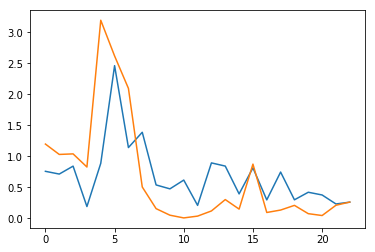

In [142]:
%matplotlib inline

plt.plot(range(scores.shape[0]), scores[:, 0].numpy())
plt.plot(range(scores.shape[0]), scores[:, 1].numpy())
plt.show()